In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

from tqdm import tqdm_notebook
import os
import glob
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate, integrate
from scipy import spatial
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
import importlib
from IPython.display import display, HTML
import pandas as pd
import pickle

import matplotlib
from matplotlib import pyplot as plt
# from matplotlib import colors as mcolors
import matplotlib.colors as colors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

from time import time
from src.support_class import *
from src import jeffery_model as jm
from codeStore import support_fun as spf
from codeStore import support_fun_table as spf_tb

# %matplotlib notebook

rc('animation', html='html5')
fontsize = 40
PWD = os.getcwd()

In [ ]:
# calculate the phase map as function of theta and phi. 
# show theta, phi, and eta, here eta is the angle between the helix norm and the y axis. 

# calculate Table result
importlib.reload(jm)

for ini_psi in np.linspace(0, 2 * np.pi, 15, endpoint=0)[:]:
    max_t = 10
#     n_theta = 48
#     n_phi = 48
    n_theta = 4
    n_phi = 4
    t0 = time()
    idx_list = []
    Table_t_list = []
    Table_theta_list = []
    Table_phi_list = []
    Table_psi_list = []
    Table_eta_list = []
    ini_theta_list = []
    ini_phi_list = []
    idx = 0
    planeShearRate = np.array((1, 0, 0))
    for ini_theta in tqdm_notebook(np.linspace(0, np.pi, n_theta), desc='$\\psi_{ini}$=%5.3f' % ini_psi):
        for ini_phi in np.linspace(0, 2 * np.pi, n_phi):
            tnorm = np.array((np.sin(ini_theta) * np.cos(ini_phi), 
                              np.sin(ini_theta) * np.sin(ini_phi), 
                              np.cos(ini_theta)))
            Table_t, Table_X, Table_P, Table_P2, Table_theta, Table_phi, Table_psi, Table_eta \
                = do_calculate_ecoli_RK(norm, ini_psi, max_t, update_fun=integrate.RK45, 
                                        rtol=1e-3, atol=1e-6)
            idx_list.append(idx)
            Table_t_list.append(Table_t)
            Table_theta_list.append(Table_theta)
            Table_phi_list.append(Table_phi)
            Table_psi_list.append(Table_psi)
            Table_eta_list.append(Table_eta)
            ini_theta_list.append(ini_theta)
            ini_phi_list.append(ini_phi)
            idx = idx + 1
    data = pd.DataFrame({'ini_theta':  np.hstack(ini_theta_list), 
                         'ini_phi':    np.hstack(ini_phi_list), 
                         'idx':    np.hstack(idx_list), 
                         'last_theta': np.hstack([Table_theta[-1] for Table_theta in Table_theta_list]), 
                         'last_phi':   np.hstack([Table_phi[-1] for Table_phi in Table_phi_list]), 
                         'last_psi':   np.hstack([Table_psi[-1] for Table_psi in Table_psi_list]), 
                         'last_eta':   np.hstack([Table_eta[-1] for Table_eta in Table_eta_list]), 
                        }).pivot_table(index=['ini_theta', 'ini_phi'])
    idx = data.idx.unstack()
    last_theta = data.last_theta.unstack()
    last_phi = data.last_phi.unstack()
    last_psi = data.last_psi.unstack()
    last_eta = data.last_eta.unstack()
    t1 = time()
    print('calculate phase map: run %d cases using %fs' % ((n_theta * n_phi), (t1 - t0)))

    tpick = (idx, ini_psi, last_theta, last_phi, last_eta, last_psi, 
             Table_t_list, Table_theta_list, Table_phi_list, Table_psi_list, Table_eta_list)
    with open('phase_map_ecoli_%5.3f.pickle' % ini_psi, 'wb') as handle:
        pickle.dump(tpick, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('save table_data to phase_map_ecoli_%5.3f.pickle' % ini_psi)


In [ ]:
def tplot_fun(ax0, file_handle, t1, vmin=0, vmax=np.pi):
    tx = t1.columns.values
    ty = t1.index.values
    plt.sca(ax0)
    im = ax0.pcolor(tx / np.pi, ty / np.pi, t1.values / np.pi, 
                    cmap=cm.RdBu, vmin=vmin / np.pi, vmax=vmax / np.pi)
    fig.colorbar(im, ax=ax0).ax.tick_params(labelsize=fontsize*0.8)
    ax0.set_xlabel('$\\phi / \pi$', size=fontsize)
    ax0.set_ylabel('$\\theta / \pi$', size=fontsize)
    ax0.set_title('%s' % file_handle, size=fontsize*0.8)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
    return True

with open('phase_map_ecoli_0.000.pickle', 'rb') as handle:
    tpick = pickle.load(handle)
idx, ini_psi, last_theta, last_phi, last_eta, last_psi, \
  Table_t_list, Table_theta_list, Table_phi_list, Table_psi_list, Table_eta_list = tpick

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(100, 20))
fig.patch.set_facecolor('white')

tplot_fun(ax0, 'last_eta', last_eta, vmin=0, vmax=np.pi)
tplot_fun(ax1, 'last_theta', last_theta, vmin=0, vmax=np.pi)
tplot_fun(ax2, 'last_phi', last_phi, vmin=0, vmax=2 * np.pi)
tplot_fun(ax3, 'last_psi', last_psi, vmin=0, vmax=2 * np.pi)
pass


In [ ]:
display(idx[:0.3*np.pi].T[np.pi:1.7*np.pi].T)
display(last_eta[:0.3*np.pi].T[np.pi:1.7*np.pi].T / np.pi)
display(last_psi[:0.3*np.pi].T[np.pi:1.7*np.pi].T / np.pi)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
display(last_eta / np.pi)

In [ ]:
show_idx = 74

tt = Table_t_list[show_idx]
ttheta = Table_theta_list[show_idx]
tphi = Table_phi_list[show_idx]
tpsi = Table_psi_list[show_idx]
teta = Table_eta_list[show_idx]

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, ncols=1, figsize=(20, 20))
fig.patch.set_facecolor('white')
ax0.plot(tt, ttheta, '-*')
ax1.plot(tt, tphi, '-*')
ax2.plot(tt, tpsi, '-*')
ax3.plot(tt, teta, '-*')
print(ttheta[0], ',', tphi[0], ',', tpsi[0])

load table_data from idx002_th0.000_ph0.000_ps0.000.pickle


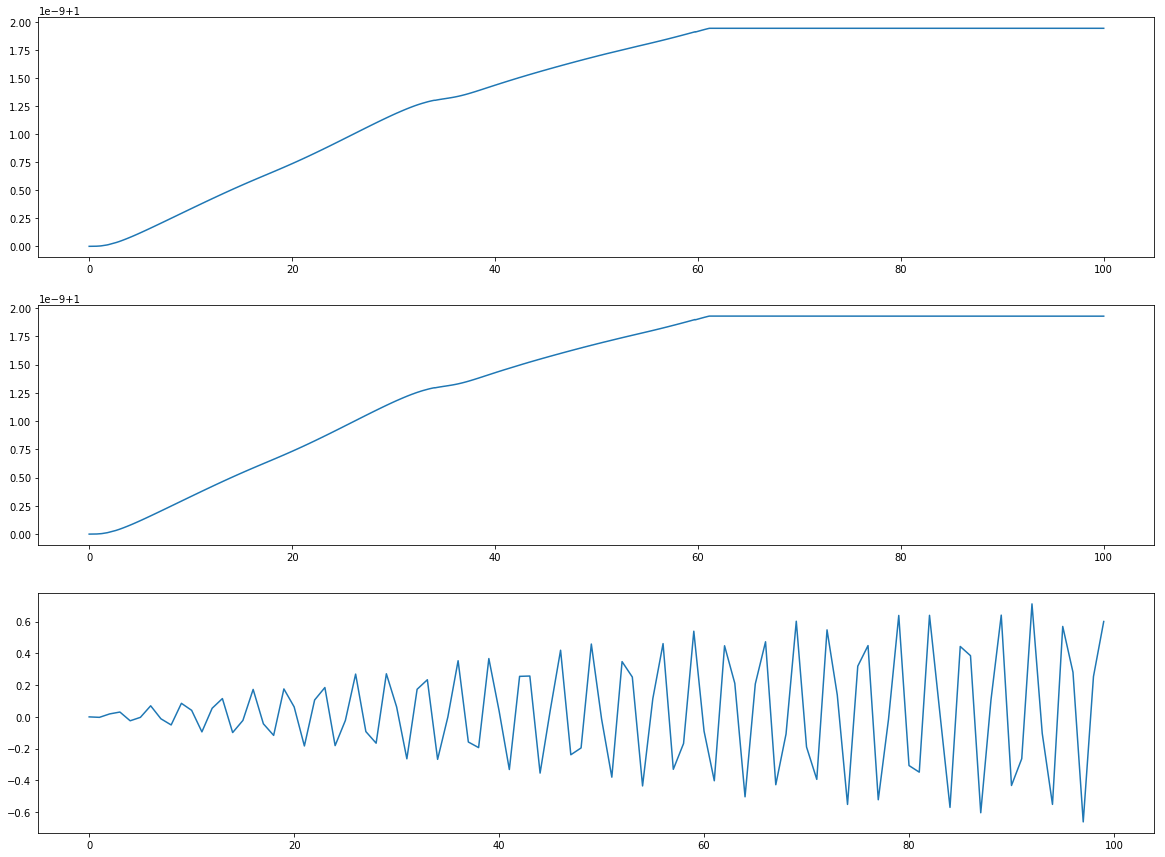

In [18]:
idx = 2
t_theta, t_phi, t_psi = 0, 0, 0
t_name = 'idx%03d_th%5.3f_ph%5.3f_ps%5.3f.pickle' % (idx, t_theta, t_phi, t_psi)

with open('../motion_ecoliB01_table/%s' % t_name, 'rb') as handle:    
    tpick = pickle.load(handle)
t_theta, t_phi, t_psi, max_t, update_fun, rtol, atol, eval_dt, \
    Table_t, Table_X, Table_P, Table_P2, Table_theta, Table_phi, Table_psi, Table_eta = tpick
save_every = np.ceil(1 / eval_dt) / 100
print('load table_data from %s' % t_name)

spf_tb.show_table_result(Table_t, Table_theta, Table_phi, Table_psi, Table_eta, Table_X, save_every)

In [ ]:
t0 = 0
t1 = t0 + 1000
idx = (t0 < Table_t) & (Table_t <  t1)

fig = plt.figure(figsize=(10, 10))
ax0 = fig.add_subplot(111, polar=True)
fig.patch.set_facecolor('white')

norm=plt.Normalize(Table_t.min(), Table_t.max())
cmap=plt.get_cmap('jet')
ax0.plot(Table_phi / np.pi, Table_theta / np.pi, ' ')
lc = ax0.scatter(Table_phi[idx], Table_theta[idx], c=Table_t[idx], cmap=plt.get_cmap('jet'), s=fontsize*0.1)
clb = fig.colorbar(lc, ax=ax0, orientation="vertical")
clb.ax.tick_params(labelsize=fontsize*0.5)
clb.ax.set_title('time', size=fontsize*0.5)
# ax0.set_xlabel('$\\phi / \pi$', size=fontsize*0.7)
# ax0.set_ylabel('$\\theta / \pi$', size=fontsize*0.7)
ax0.set_ylim(0,np.pi)
plt.sca(ax0)
plt.xticks(fontsize=fontsize*0.5)
plt.yticks(fontsize=fontsize*0.5)


In [ ]:
anim = spf_tb.make_table_video(Table_t, Table_X, Table_P, Table_P2, 
                               Table_theta, Table_phi, Table_psi, Table_eta,
                               zm_fct=30, stp=1, interval=20)
# anim
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
# anim.save('tmp.mp4', writer=writer)

In [ ]:
# active ecoli petsc family method 
importlib.reload(spf_tb)
t0 = time()
t_theta, t_phi, t_psi = 0, 0, 0
max_t = 100
update_fun='1fe'
rtol=1e-6
atol=1e-9
eval_dt = 0.0001
save_every = np.ceil(1 / eval_dt / 100)

tnorm = np.array((np.sin(t_theta) * np.cos(t_phi), np.sin(t_theta) * np.sin(t_phi), np.cos(t_theta)))
Table_t, Table_X, Table_P, Table_P2, Table_theta, Table_phi, Table_psi, Table_eta \
   = spf_tb.do_calculate_ecoli_Petsc(tnorm, t_psi, max_t, update_fun=update_fun, 
                                     rtol=rtol, atol=atol, eval_dt=eval_dt, 
                                     save_every=save_every)
t1 = time()
print('last norm: ', Table_theta[-1], ',', Table_phi[-1], ',', Table_psi[-1])
print('%s: run %d loops/times using %fs' % ('do_calculate_ecoli_Petsc', max_t, (t1 - t0)))
print('%s_%s rt%.0e, at%.0e, dt%.0e %.1fs' % ('PETSC RK', update_fun, rtol, atol, eval_dt, (t1 - t0)))
spf_tb.show_table_result(Table_t, Table_X, Table_P, Table_P2, 
                         Table_theta, Table_phi, Table_psi, Table_eta, save_every)

t_pick = (t_theta, t_phi, t_psi, max_t, update_fun, rtol, atol, eval_dt, 
          Table_t, Table_X, Table_P, Table_P2, Table_theta, Table_phi, Table_psi, Table_eta, save_every)
idx = np.load('../motion_ecoliB01_table/idx.npy')
t_name = 'idx%03d_th%5.3f_ph%5.3f_ps%5.3f.pickle' % (idx, t_theta, t_phi, t_psi)
np.save('../motion_ecoliB01_table/idx.npy', (idx + 1))
with open('../motion_ecoliB01_table/%s' % t_name, 'wb') as handle:    
    pickle.dump(t_pick, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('save to %s' % t_name)

In [58]:
a = quaternion.from_float_array((1,0,0,0))
# a = quaternion.from_rotation_vector((0, 0, np.pi / 2))
a
quaternion.as_float_array(a)

array([ 1.,  0.,  0.,  0.])

In [116]:
def rotMatrix_DCM(x0, y0, z0, x, y, z):
    # Diebel, James. "Representing attitude: Euler angles, unit quaternions, and rotation vectors." 
    #  Matrix 58.15-16 (2006): 1-35.
    # eq. 17
    # https://arxiv.org/pdf/1705.06997.pdf
    # appendix B
    # Graf, Basile. "Quaternions and dynamics." arXiv preprint arXiv:0811.2889 (2008).
    # 
    # A rotation matrix may also be referred to as a direction
    # cosine matrix, because the elements of this matrix are the
    # cosines of the unsigned angles between the body-¯xed axes
    # and the world axes. Denoting the world axes by (x; y; z)
    # and the body-fixed axes by (x0; y0; z0), let \theta_{x';y} be,
    # for example, the unsigned angle between the x'-axis and the y-axis.
    
    # (x0, y0, z0)^T = dot(R, (x, y, z)^T )
    
    R = np.array(((np.dot(x0, x), np.dot(x0, y), np.dot(x0, z)),
                  (np.dot(y0, x), np.dot(y0, y), np.dot(y0, z)),
                  (np.dot(z0, x), np.dot(z0, y), np.dot(z0, z))))
    return R

eglb = np.identity(3)
tR0 = rot_vec2rot_mtx(np.random.sample(3))
e0 = np.dot(tR0, eglb)
tR = rot_vec2rot_mtx(np.random.sample(3))
e = eglb.copy()
R = rotMatrix_DCM(*e0, *e)
print(e)
print(e0)
print(R)
print(np.max(np.abs(np.dot(R, e) - e0)))


[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
[[ 0.85685 -0.14847  0.49373]
 [ 0.27327  0.94284 -0.19073]
 [-0.43718  0.29835  0.84844]]
[[ 0.85685 -0.14847  0.49373]
 [ 0.27327  0.94284 -0.19073]
 [-0.43718  0.29835  0.84844]]
0.0


In [186]:
importlib.reload(jm)

eglb = np.identity(3)
e = eglb.copy()
# tR0 = rot_vec2rot_mtx(np.random.sample(3))
tR0 = rot_vec2rot_mtx(np.ones(3))
e0 = np.dot(tR0, eglb)
tR = rotMatrix_DCM(*e0, *e)

q0 = jm.Quaternion()
q0.set_wxyz(*quaternion.as_float_array(quaternion.from_rotation_matrix(tR)))
# # make sure e0 and q0 is same frame
# print(e0)
# print(q0.get_R())
# print(np.linalg.norm(e0, axis=0))
# print(np.dot(e0[0], e0[1]), np.dot(e0[0], e0[2]), np.dot(e0[1], e0[2]))
# print(np.linalg.norm(e0, axis=1))
# print(np.dot(e0.T[0], e0.T[1]), np.dot(e0.T[0], e0.T[2]), np.dot(e0.T[1], e0.T[2]))

# rotate by omega and dt
dt = 1
# omega = np.random.sample(3)
omega = np.ones(3)
rot_mtx = get_rot_matrix(norm=omega / np.linalg.norm(omega), theta=np.linalg.norm(omega) * dt)
e1 = np.dot(rot_mtx, e0)
dq = 0.5 * np.dot(omega, q0.get_G())
q1 = q0 + dq * dt
q1.normalize()
tqw, tqx, tqy, tqz = q0.q
Qq = np.array(((tqw, -tqx, -tqy, -tqz), 
               (tqx,  tqw,  tqz, -tqy), 
               (tqy, -tqz,  tqw,  tqx), 
               (tqz,  tqy, -tqx,  tqw)))
re_omega = 2 * np.dot(Qq.T, dq)[1:4]
# print(omega, re_omega)

# check if sure e0 and q0 is same frame
print(e1)
print(q1.get_R())
# print(q1.q, np.linalg.norm(q1.q))
print(np.linalg.norm(e1 - q1.get_R()) / dt)


[[-0.29896  0.83247  0.46649]
 [ 0.46649 -0.29896  0.83247]
 [ 0.83247  0.46649 -0.29896]]
[[-0.33323  0.67695  0.65628]
 [ 0.65628 -0.33323  0.67695]
 [ 0.67695  0.65628 -0.33323]]
[-0.00895  0.57733  0.57733  0.57733] 1.0
0.4291089428


[-0.99859 -0.05872 -0.05872 -0.05872] -0.998591067687 -0.0587198778015 -0.0587198778015 -0.0587198778015
